# Курсовой проект

### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

### Наименование файлов с данными

course_project_train.csv - обучающий датасет  
course_project_test.csv - тестовый датасет

### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

### Метрика качества

F1-score (sklearn.metrics.f1_score)

### Требования к решению

Целевая метрика  
```
F1 > 0.5    
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
```
Решение должно содержать    
```
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb    
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
```
Рекомендации для файла с кодом (ipynb)    

1. Файл должен содержать заголовки и комментарии (markdown)      
2. Повторяющиеся операции лучше оформлять в виде функций    
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)    
4. По возможности добавлять графики, описывающие данные (около 3-5)    
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта    
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)      
7. Весь проект должен быть в одном скрипте (файл ipynb).    
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.   

## Обзор данных

### Описание датасета

--**Home Ownership** - домовладение   
--**Annual Income** - годовой доход  
--**Years in current job** - количество лет на текущем месте работы  
--**Tax Liens** - налоговые обременения  
--**Number of Open Accounts** - количество открытых счетов  
--**Years of Credit History** - количество лет кредитной истории  
--**Maximum Open Credit** - наибольший открытый кредит  
--**Number of Credit Problems** - количество проблем с кредитом  
--**Months since last delinquent** - количество месяцев с последней просрочки платежа  
--**Bankruptcies** - банкротства  
--**Purpose** - цель кредита  
--**Term** - срок кредита  
--**Current Loan Amount** - текущая сумма кредита  
--**Current Credit Balance** - текущий кредитный баланс  
--**Monthly Debt** - ежемесячный долг  
--**Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)  

In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

### Импорт библиотек

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve



from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier


from sklearn.metrics import classification_report, f1_score, precision_score, recall_score


from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import probplot

### Загрузка данных

In [3]:
TRAIN_DATASET_PATH = 'c:/data2/course_project_train.csv'
TEST_DATASET_PATH = 'c:/data2/course_project_test.csv'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)
train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [5]:
test.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,NaN,5 years,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
9,Home Mortgage,2140445.0,10+ years,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


In [6]:
train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [7]:
test.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

In [8]:
def reduce_mem_usage(df):
    """   перебирает все столбцы фрейма и изменяет тип данных
        для уменьшения использования памяти.      
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
def mis_values_report(df):
    '''Функция считает и выводит пропущенные значения столбцов датафрейма'''
    mis_val = df.isnull().sum()
    perc_mis_val = 100 * df.isnull().sum() / len(df)
    report = pd.concat([mis_val, perc_mis_val], axis=1)
    report_columns = report.rename(columns = {0: 'Пропущенные значения', 1: '% от всех значений'})
    report_columns = report_columns[report_columns.iloc[:,1] != 0].sort_values('% от всех значений', ascending=False).round(1)
    print('Датафрейм имеет ' + str(df.shape[1]) + ' столбцов.\n' + str(report_columns.shape[0]) + ' столбцов имеют пропущенные значения')
    return report_columns

In [10]:

def hist_qq(target_name):
    '''Функция для построения графиков'''
    plt.figure(figsize=(16,8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    train[target_name].hist()
    plt.subplot(122)
    probplot(train[target_name],dist='norm',plot=plt)

    plt.show()
    

### Функции для обароботки данных

In [11]:
def df_fix_Home_Ownership(df):  # преобразуем категариальный признак
    df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='Home Ownership')], axis=1)
    df.drop(['Home Ownership'], axis=1, inplace=True)
    return df

In [12]:
def df_fix_Annual_Income(df):  # заменяем пропуски и выбрасы на медиану
    df.loc[df['Annual Income'].isnull(), 'Annual Income'] = df['Annual Income'].median()
    df.loc[df['Annual Income'] > df['Annual Income'].quantile(.99), ['Annual Income']] =\
            df['Annual Income'].median()
    return df

In [13]:
def df_fix_Years_in_current_job(df):   # преобразуем в числовой вид, пропуски запишим в отдельное значение
    df['Years in current job'] = df['Years in current job'].map({
                                                                '10+ years':'10', 
                                                                '9 years':'9',
                                                                '8 years':'8',
                                                                '7 years':'7',
                                                                '6 years':'6',
                                                                '5 years':'5',
                                                                '4 years':'4',
                                                                '3 years':'3',
                                                                '2 years':'2',
                                                                '1 year':'1',
                                                                '< 1 year':'0'
                                                                }).astype(float)

    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 11
    return df

In [14]:
def df_fix_Number_of_Open_Accounts(df): # выбросы заполняем медианой
    df.loc[df['Number of Open Accounts'] > df['Number of Open Accounts'].quantile(.95), ['Number of Open Accounts']] =\
                df['Number of Open Accounts'].median()
    return df

In [15]:
def df_fix_Maximum_Open_Credit(df): # выбросы заполняем медианой
    df.loc[train['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
                df['Maximum Open Credit'].median()
    return df

In [16]:
def df_fix_Bankruptcies(df): # пропуски запишем в ноль
    df.loc[train['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
    return df

In [17]:
def df_fix_Months_since_last_delinquent(df): # пропуски запишем в ноль
    df['Months since last delinquent'].fillna(0, inplace=True)
    return df

In [18]:
def df_fix_Purpose(df): # преобразуем категариальный признак
    df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose')], axis=1)
    df.drop(['Purpose'], axis=1, inplace=True)
    return df

In [19]:
def df_fix_Term(df): # преобразуем категариальный признак
    df = pd.concat([df, pd.get_dummies(df['Term'], prefix='Term')], axis=1)
    df.drop(['Term'], axis=1, inplace=True)                  
    return df

In [20]:
def df_fix_Current_Loan_Amount(df): # выбрасы заполним  медианой
    df.loc[(df['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = df['Current Loan Amount'].median()
    return df

In [21]:
def df_fix_Current_Credit_Balance(df): # выбрасы заменим на медиану
    df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.95), \
           ['Current Credit Balance']] = df['Current Credit Balance'].median()
    return df

In [22]:
def df_fix_Monthly_Debt(df): # выбрасы заменим на медиану
    df.loc[df['Monthly Debt'] > df['Monthly Debt'].quantile(.99), \
           ['Monthly Debt']] = df['Monthly Debt'].median()
    return df

In [23]:
def df_fix_Credit_Score(df):    # созданим новый признак известин кредитный рейтинг или нет, пропуски заполним медианой
    df['unknown_credit_score'] = 0
    df.loc[(train['Credit Score'].isnull()), 'unknown_credit_score'] = 1
    df.loc[(train['Credit Score'].isnull()), 'Credit Score'] = df['Credit Score'].median()
    return df

In [24]:
def data_prepare(df):
    '''Функция для обработки Test данных'''
    df = df_fix_Home_Ownership(df)
    df = df_fix_Annual_Income(df)
    df = df_fix_Years_in_current_job(df)
    df = df_fix_Number_of_Open_Accounts(df)
    df = df_fix_Maximum_Open_Credit(df)
    df = df_fix_Bankruptcies(df)
    df = df_fix_Months_since_last_delinquent(df)
    df = df_fix_Purpose(df)
    df = df_fix_Term(df)
    df = df_fix_Current_Loan_Amount(df)
    df = df_fix_Current_Credit_Balance(df)
    df = df_fix_Monthly_Debt(df)
    df = df_fix_Credit_Score(df)
    return df

In [25]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [26]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [27]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [28]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


In [29]:
train.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

In [30]:
 mis_values_report(train)

Датафрейм имеет 17 столбцов.
5 столбцов имеют пропущенные значения


,Пропущенные значения,% от всех значений
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


## Обработка данных¶

**Home Ownership** - домовладение 

In [31]:
train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

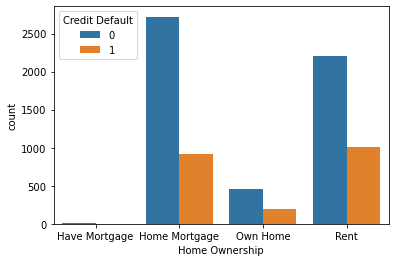

In [32]:
sns.countplot(x="Home Ownership", hue='Credit Default', data=train)
plt.show()

In [33]:
train = df_fix_Home_Ownership(train)

 **Annual Income** - годовой доход 

<AxesSubplot:xlabel='Annual Income'>

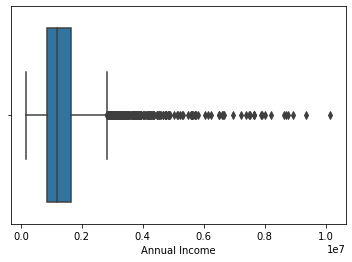

In [34]:
sns.boxplot(x=train['Annual Income'])

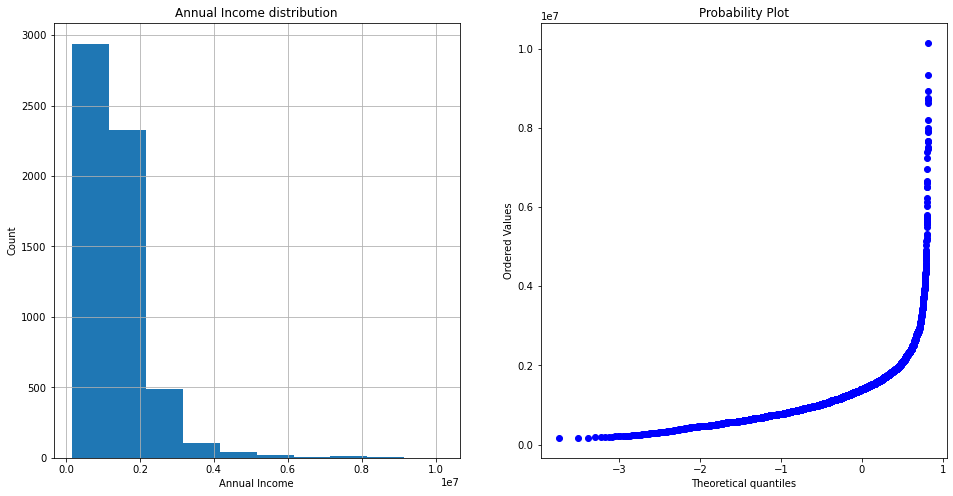

In [35]:
hist_qq('Annual Income')

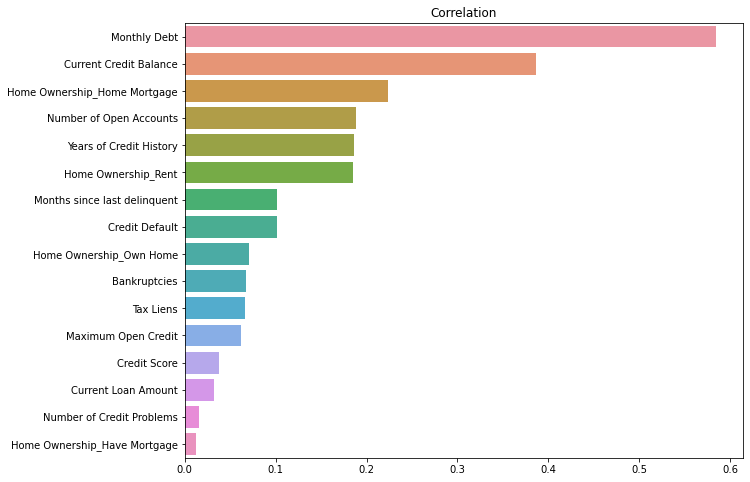

In [36]:
FEATURE_NAMES = train.columns.drop('Annual Income').tolist()
corr_Annual_Income = train[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')
plt.show()

In [37]:
train = df_fix_Annual_Income(train)

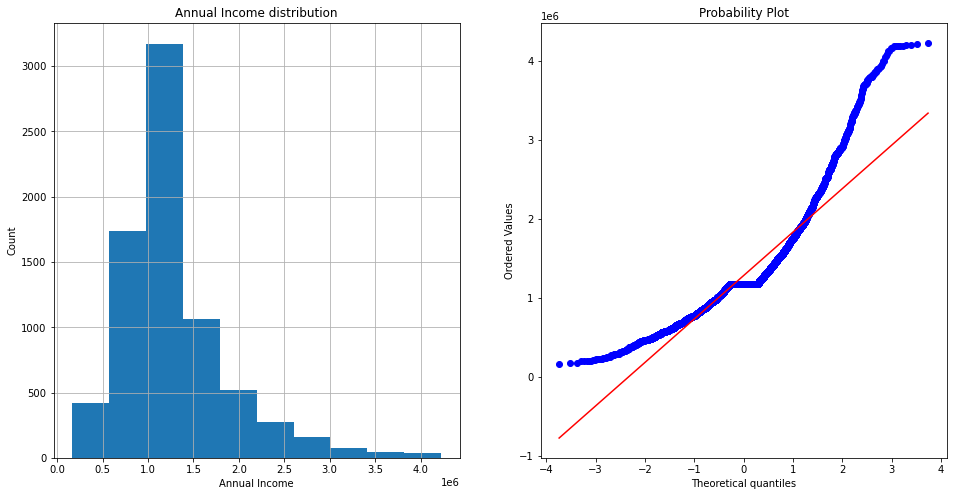

In [38]:
hist_qq('Annual Income')

**Years in current job** - количество лет на текущем месте работы

In [39]:
train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

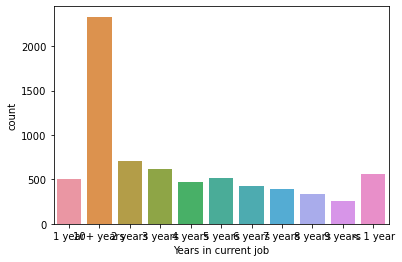

In [40]:
sns.countplot(x="Years in current job", data=train)
plt.show()

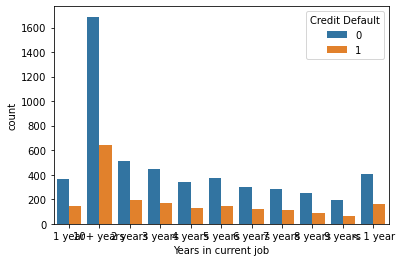

In [41]:
sns.countplot(x="Years in current job", hue='Credit Default', data=train)
plt.show()

In [42]:
train = df_fix_Years_in_current_job(train)

**Tax Liens** - налоговые обременения

In [43]:
train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

**Number of Open Accounts** - количество открытых счетов 

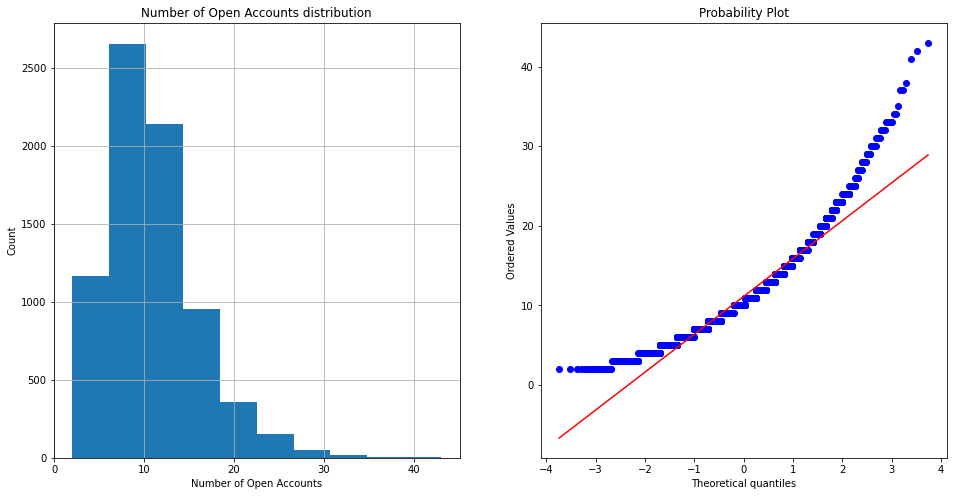

In [44]:
hist_qq('Number of Open Accounts')

In [45]:
train = df_fix_Number_of_Open_Accounts(train)

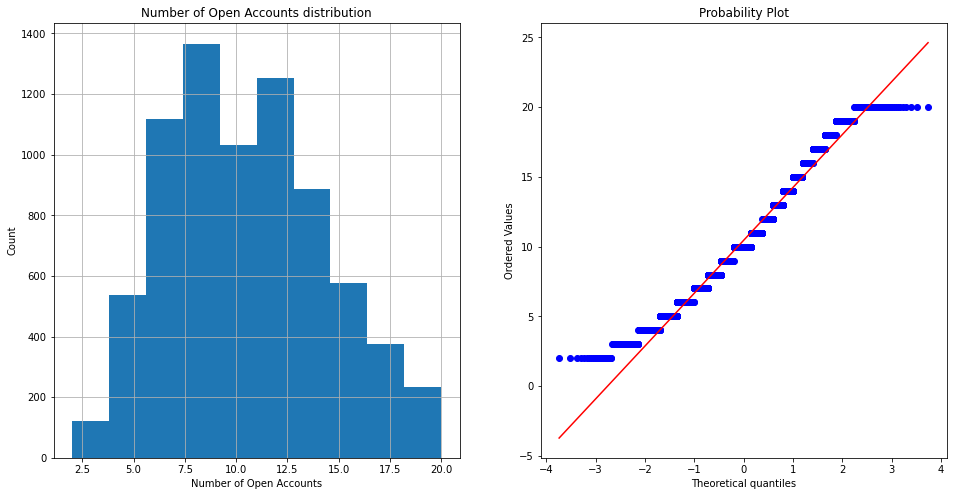

In [46]:
hist_qq('Number of Open Accounts')

**Years of Credit History** - коичество лет кредитной истории

<AxesSubplot:>

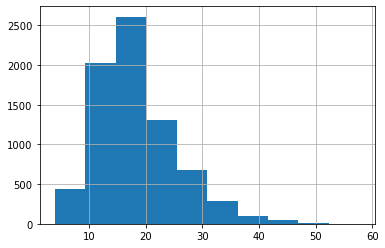

In [47]:
train['Years of Credit History'].hist()

**Maximum Open Credit** - наибольший открытый кредит ¶

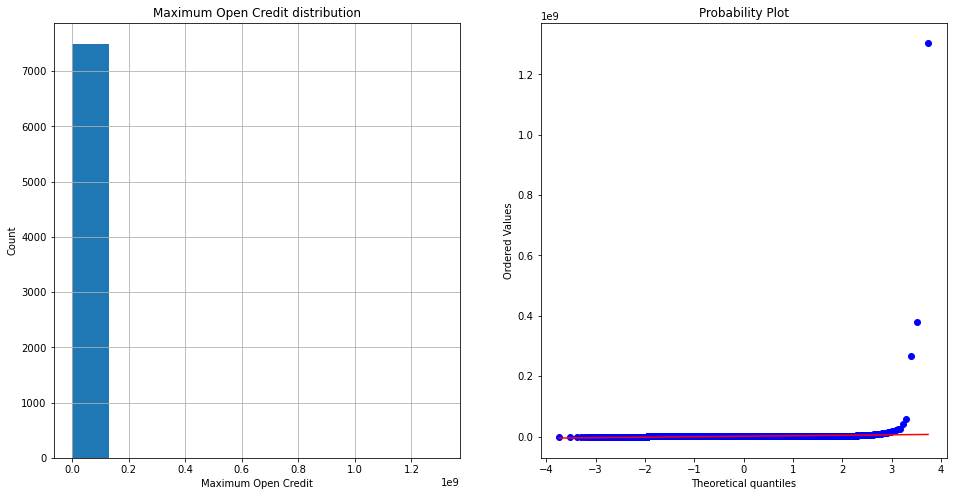

In [48]:
hist_qq('Maximum Open Credit')

In [49]:
train = df_fix_Maximum_Open_Credit(train)

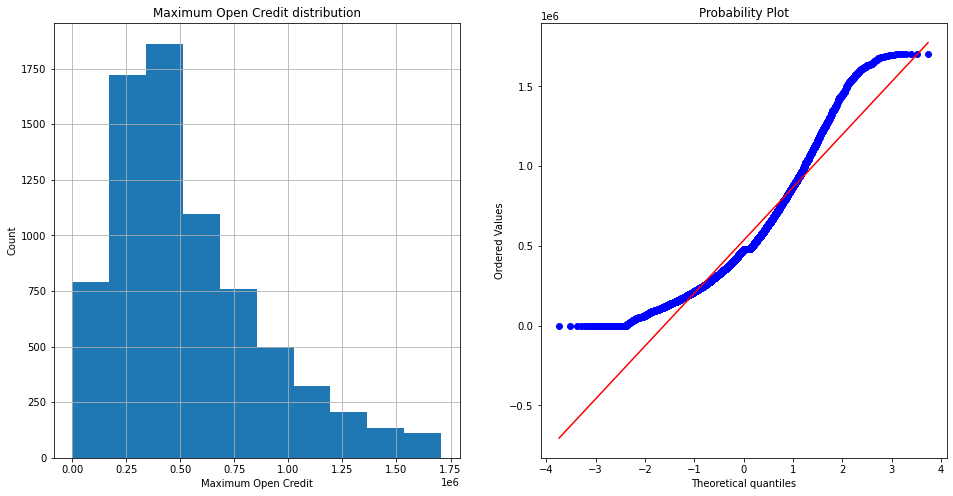

In [50]:
hist_qq('Maximum Open Credit')

**Number of Credit Problems** - количество проблем с кредитом

In [51]:
train['Number of Credit Problems'].value_counts()


0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

**Bankruptcies** - банкротства

In [52]:
train = df_fix_Bankruptcies(train)

**Months since last delinquent** - количество месяцев с последней просрочки кредита

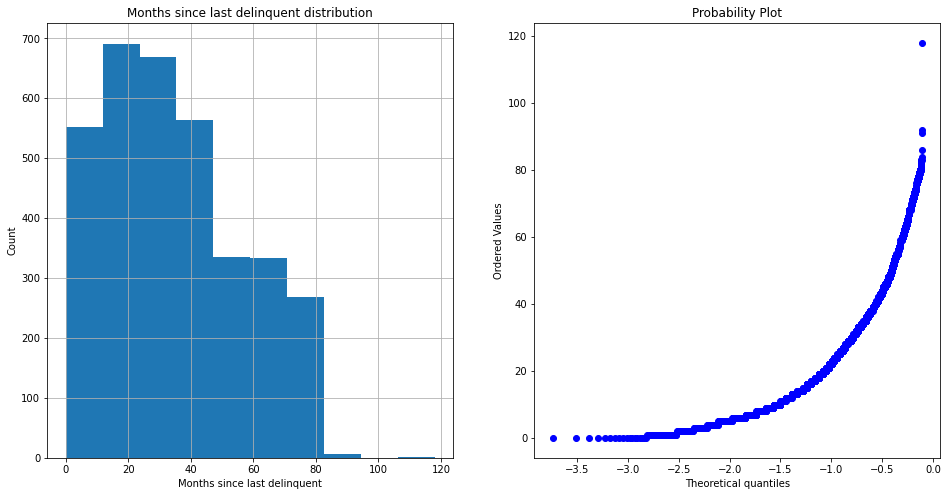

In [53]:
hist_qq('Months since last delinquent')

In [54]:
train = df_fix_Months_since_last_delinquent(train)

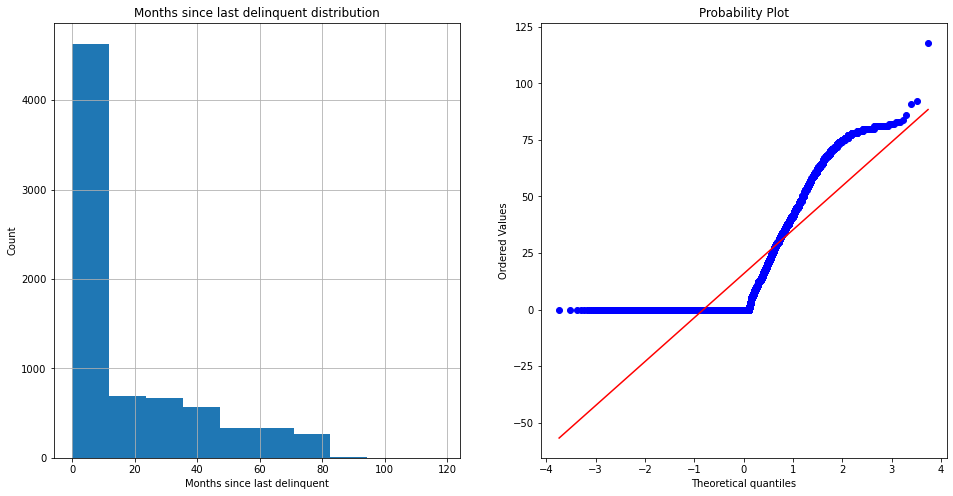

In [55]:
hist_qq('Months since last delinquent')

**Purpose** - цель кредита

In [56]:
train = df_fix_Purpose(train)

**Term** - срок кредита

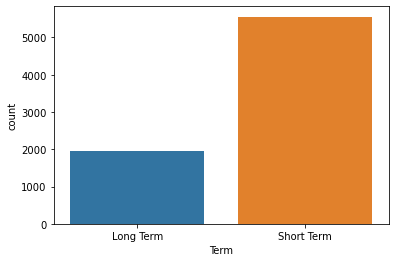

In [57]:
sns.countplot(x="Term", data=train)
plt.show()

In [58]:
train = df_fix_Term(train)
train. head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,482087.0,11.0,0.0,11.0,26.299999,685960.0,1.0,0.0,1.0,100000000.0,...,0,0,0,0,0,0,0,0,0,1
1,1025487.0,10.0,0.0,15.0,15.300000,1181730.0,0.0,0.0,0.0,264968.0,...,0,0,0,0,0,0,0,0,1,0
2,751412.0,8.0,0.0,11.0,35.000000,1182434.0,0.0,0.0,0.0,100000000.0,...,0,0,0,0,0,0,0,0,0,1
3,805068.0,6.0,0.0,8.0,22.500000,147400.0,1.0,0.0,1.0,121396.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,8.0,0.0,13.0,13.600000,385836.0,1.0,0.0,0.0,125840.0,...,0,0,0,0,0,0,0,0,0,1


**Current Loan Amount** - текущая сумма кредита

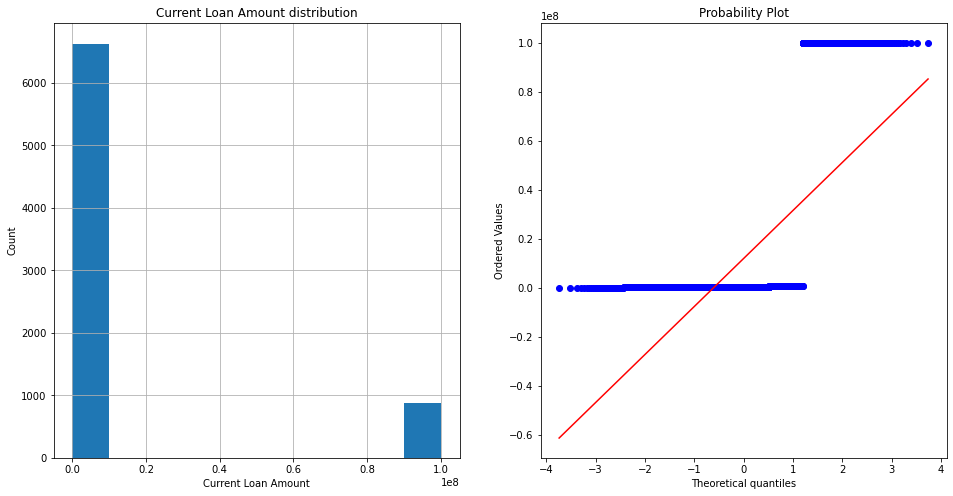

In [59]:
hist_qq('Current Loan Amount')

In [60]:
train = df_fix_Current_Loan_Amount(train)

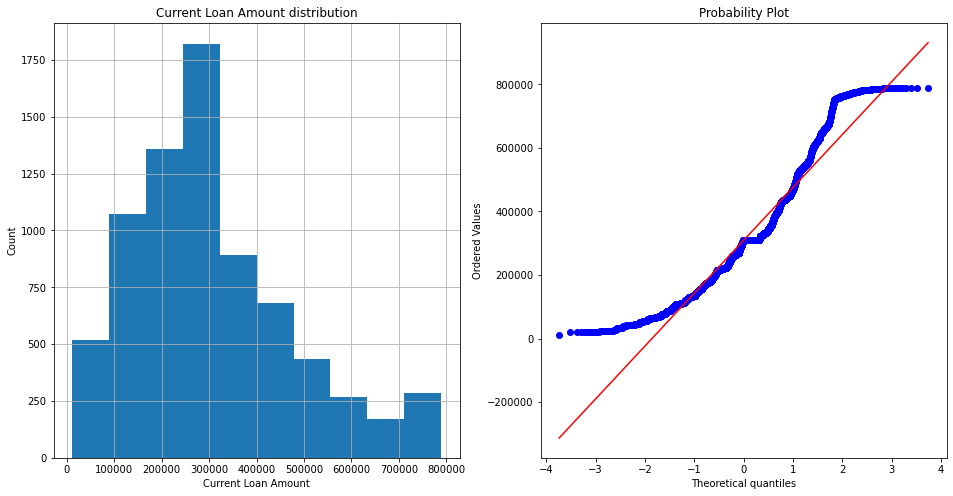

In [61]:
hist_qq('Current Loan Amount')

**Current Credit Balance** - текущий кредитный баланс

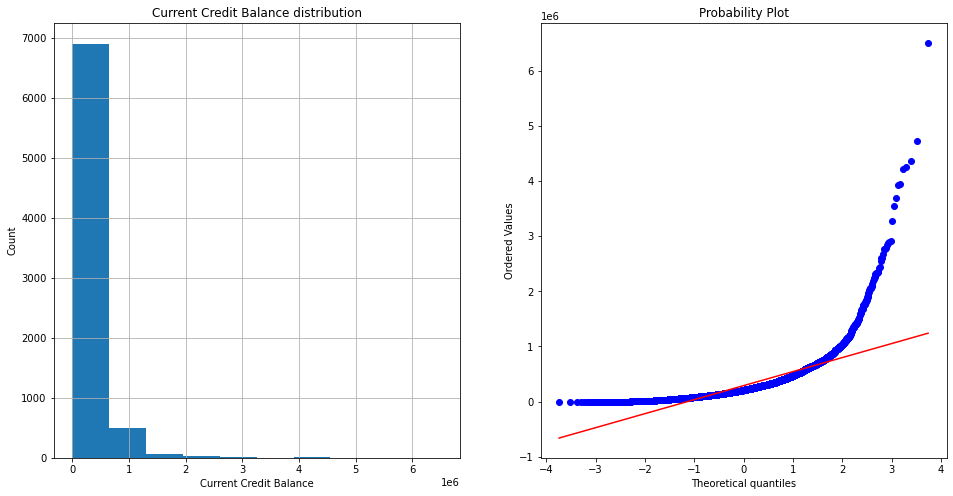

In [62]:
hist_qq('Current Credit Balance')

In [63]:
train = df_fix_Current_Credit_Balance(train)

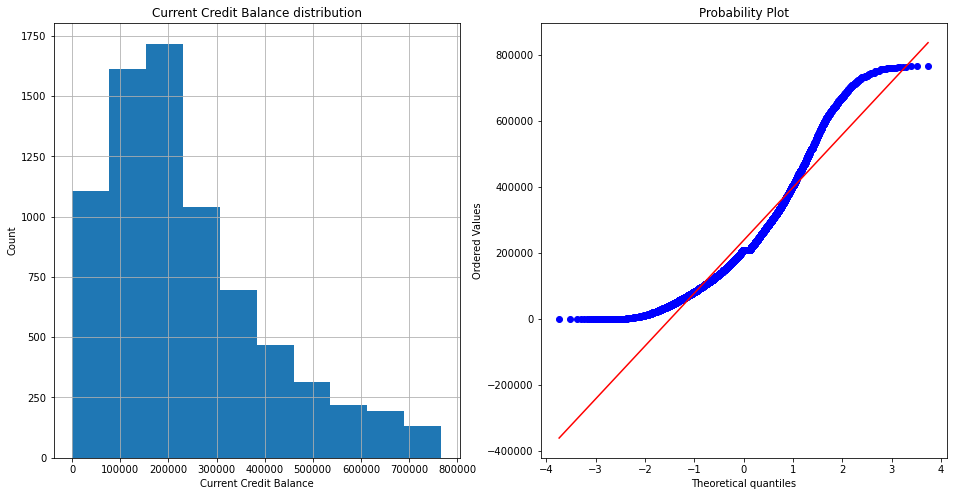

In [64]:
hist_qq('Current Credit Balance')

**Monthly Debt** - ежемесячный долг

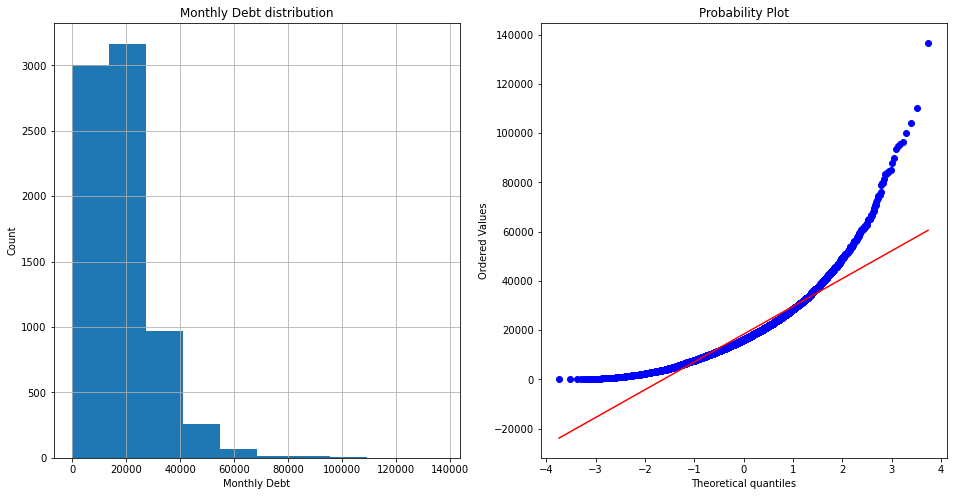

In [65]:
hist_qq('Monthly Debt')

In [66]:
train = df_fix_Monthly_Debt(train)

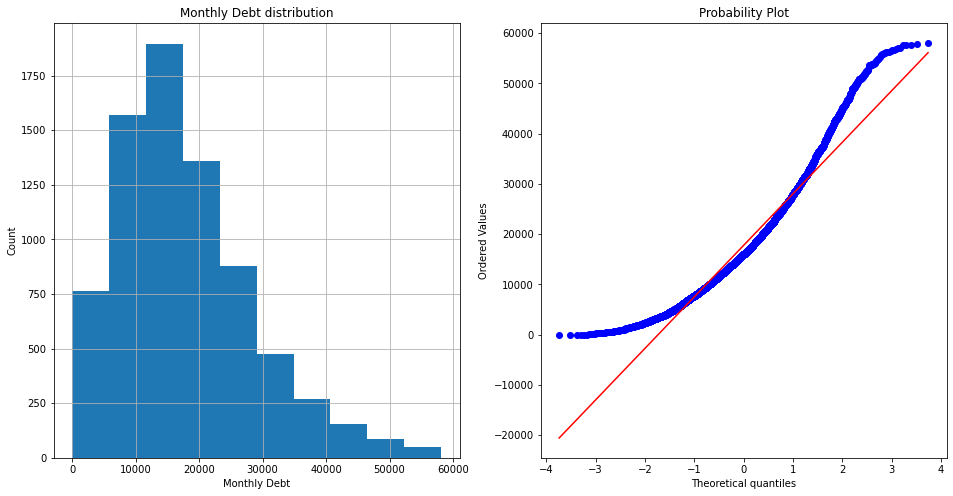

In [67]:
hist_qq('Monthly Debt')

**Credit Score** - кредитный рейтинг

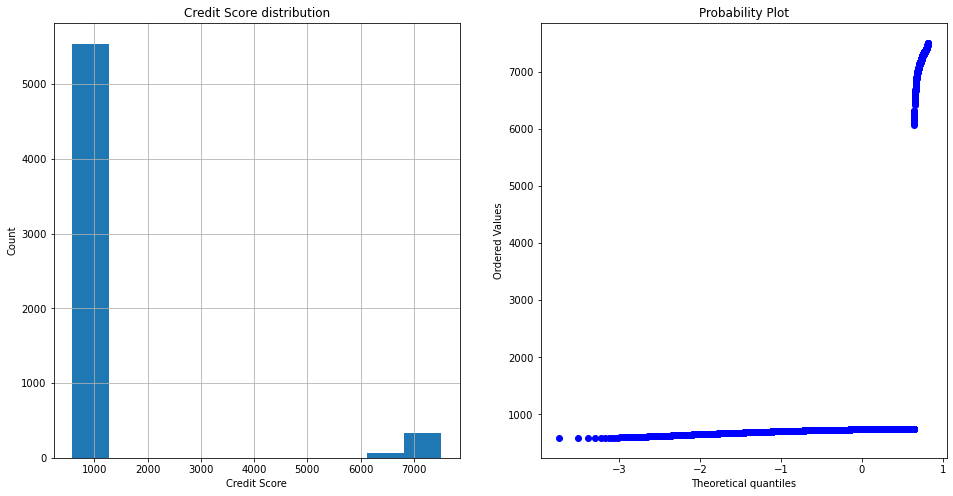

In [68]:
hist_qq('Credit Score')

In [69]:
train = df_fix_Credit_Score(train)

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float32
 1   Years in current job          7500 non-null   float64
 2   Tax Liens                     7500 non-null   float32
 3   Number of Open Accounts       7500 non-null   float32
 4   Years of Credit History       7500 non-null   float32
 5   Maximum Open Credit           7500 non-null   float32
 6   Number of Credit Problems     7500 non-null   float32
 7   Months since last delinquent  7500 non-null   float32
 8   Bankruptcies                  7500 non-null   float32
 9   Current Loan Amount           7500 non-null   float32
 10  Current Credit Balance        7500 non-null   float32
 11  Monthly Debt                  7500 non-null   float32
 12  Credit Score                  7500 non-null   float32
 13  Cre

### Выделение  целевой переменной

In [71]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train.columns.drop(TARGET_NAME).tolist()

### Нормирование данных

In [72]:
scaler = StandardScaler()

df_norm = train.copy()
df_norm[BASE_FEATURE_NAMES] = scaler.fit_transform(df_norm[BASE_FEATURE_NAMES])

df = df_norm.copy()

### Разбиение на train и test

In [73]:
X = train[BASE_FEATURE_NAMES]
y = train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [74]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [75]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [76]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [77]:
model_lgbm = lgbm.LGBMClassifier(class_weight='balanced',random_state=21)

model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3771
           1       0.84      0.93      0.88      1479

    accuracy                           0.93      5250
   macro avg       0.91      0.93      0.92      5250
weighted avg       0.94      0.93      0.93      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1616
           1       0.48      0.52      0.50       634

    accuracy                           0.71      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.72      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1266  350
1                305  329


### Важность признаков

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


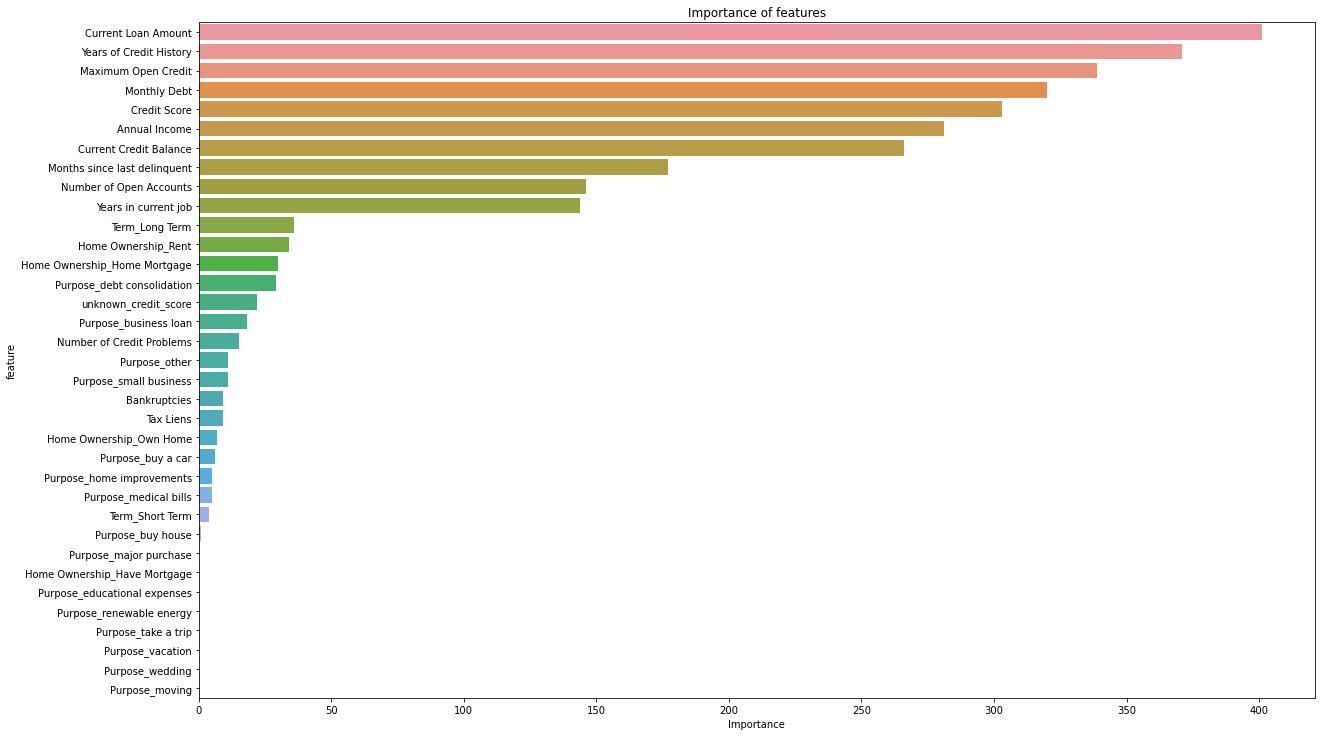

In [78]:
important_features_top = show_feature_importances(X_train.columns, model_lgbm.feature_importances_, get_top=15)

In [79]:
COL_SELECTED = ['Credit Score', 'Current Loan Amount', 'Annual Income', 'Maximum Open Credit', 'Years of Credit History', 'Monthly Debt',
                 'Current Credit Balance', 'Term_Long Term', 'Number of Open Accounts', 'Term_Short Term', 'Years in current job',
                 'Months since last delinquent', 'unknown_credit_score', 'Purpose_debt consolidation', 'Home Ownership_Home Mortgage',
                'Home Ownership_Rent', 'Number of Credit Problems', 'Purpose_business loan'
               ]

In [80]:
scaler = StandardScaler()

df_norm = train.copy()
df_norm[COL_SELECTED] = scaler.fit_transform(df_norm[COL_SELECTED])

df = df_norm.copy()

In [81]:
X = train[COL_SELECTED]
y = train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [82]:
model_lgbm = lgbm.LGBMClassifier(class_weight='balanced',random_state=21,
                                max_depth=7,min_child_samples=30,num_leaves=5,)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3771
           1       0.55      0.71      0.62      1479

    accuracy                           0.76      5250
   macro avg       0.71      0.74      0.72      5250
weighted avg       0.78      0.76      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1616
           1       0.47      0.62      0.54       634

    accuracy                           0.70      2250
   macro avg       0.65      0.68      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1180  436
1                241  393


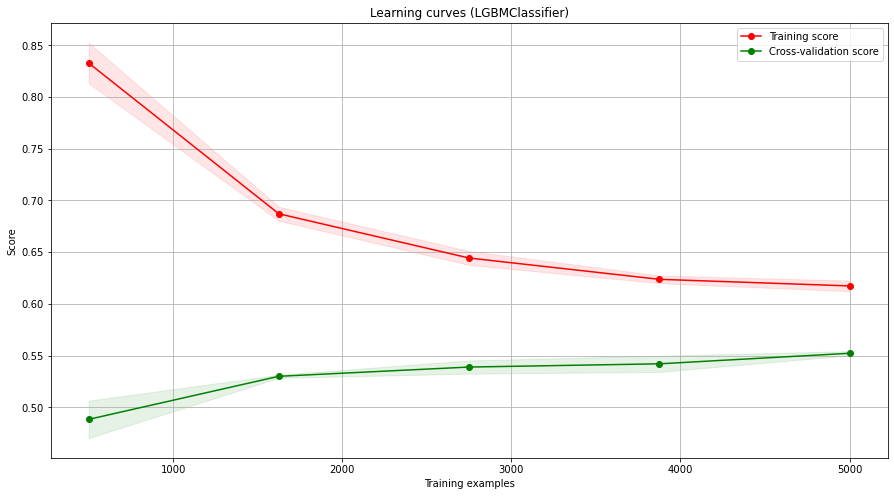

In [83]:
show_learning_curve_plot(model_lgbm, X, y)

### Подготовка тестового датасета

In [84]:
test = data_prepare(test)

In [85]:
y_pred_output = model_lgbm.predict(test[COL_SELECTED])

In [86]:
y_pred_output.shape

(2500,)

In [87]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred_output})

In [ ]:
RESULT_PATH='c:/data2/DEshtokin_predictions.csv'
result.to_csv(RESULT_PATH, index=False)

In [ ]:
SAMPLE = 'c:/data2/DEshtokin_predictions.csv'
df_sample = pd.read_csv(SAMPLE)

predictions = pd.DataFrame(index = df_sample['Id'])

predictions[TARGET_NAME] = y_pred_output
predictions